In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as hac

from scripts import config as sconfig
from scripts import dataloaders as sdataloaders
from scripts.enums import Columns, Clusters, FactTypes
from scripts.validclustindicesmod import ValidClustMod
import scripts.cluster_utils as scluster_utils
from scripts import preprocessing as sprocessing
from scripts.path_utils import *
from scripts.utils import highlight_diag

In [2]:
np.random.seed(0)
config = sconfig.Config(date_from = '2020-01-22')
dl = sdataloaders.APILoader(config)
country_config = sconfig.CountryConfig(LABEL='DEU', TIME_ZONE='Europe/Berlin')
processor = sprocessing.DataProcessor(config)
processor.load_and_prepare(dl, country_config)

DEU in store from 2020-01-22 to 2022-08-01. Store contains ['/ALL', '/DEU', '/ITA', '/ITA_preprocessed', '/NONE'].
Getting DF from Store for the dates 2020-01-22 to 2022-08-01
where_clause:  Datetime >= start_date & Datetime < end_date 
Completed loading DF of size  (18731846, 9)
Converting dateTime
Converting  Columns.YEAR
Converting  Columns.MONTH
Converting  Columns.MIN_BINS15
Finding posts per user


In [3]:
df = processor.all#.loc[~processor.all[Columns.VERIFIED.value]]
TYPE='all'

In [4]:
sns.set(rc={'figure.figsize':(7,5),
            'axes.facecolor':'white',
            'axes.edgecolor': 'black',
            'axes.spines.top': False,
            'axes.spines.right': False,
            'figure.facecolor':'white',
            'font.family': 'Helvetica',
            'xtick.bottom': True,
            'ytick.left': True,
            'xtick.color': 'black',
            'ytick.color': 'black',
            'legend.frameon': False
            })

# Pseudo-Chronotypes

We assume circadian variation on two levels: Variation in ratios of machinated content and variation in access to Twitter/capacity to tweet. We need to disentangle both effects.

## Aggregation
Ideally, we would model the time series continuously per each user over the time period that we have available, and then to separate seasonality/cyclical patterns, trend, and noise. This would allow us to isolate seasonality. However (1) that's resource-intense, (2) our data is so sparse it may not make much sense for all but the most active users and (3) few Twitter users are persistant, in that the inter-individual similarity in between subsequent days is small.

See the appendix for a comparison on aggregation over daily time intervals VS seasonal decomposition.

In [5]:
clusterer=scluster_utils.Clusterer(df, processor.posts_per_user, cutoff_post_nr=240, ratio_column=Columns.RATIO_BY_USER)

## Clustering

Let's compare hierarchical and kmeans clustering. We want at least 3 clusters for a sensible analysis. We can compare element-wise per index to find the more promising candidate.

Generally, we want to measure when people are awake, so it's important to collect all the Tweets. However, we should validate that the clusters found when considering all users are representative of Tweets by unverified users only.

In [6]:
vclust = ValidClustMod(
    indices = ['silhouette', 'calinski', 'davies', 'dunn', 'cop'],
    k=list(range(3, 10)),
    methods=['kmeans', 'hierarchical'],
    linkage="ward",
    affinity='euclidean',
)
vclust.add_index('distortion')

In [10]:
clusterer.average_over_column(wma=True, sma=False, ewa=False);

In [11]:
cvi_val_all, _ = scluster_utils.get_cluster_method(clusterer.smoothed_rhythms['wma'].transpose(), vclust=vclust)

Use hierarchical clustering.


Let's go for hierarchical clustering, as it beats kmeans in most combinations.
Here, I used agglomerative **Hierarchcal Clustering** with  **Ward's minimum variance method**. Ward's method minimizes total within-cluster variance, and is robust to noise (with no theoretical guarantees) https://jmlr.csail.mit.edu/papers/volume15/balcan14a/balcan14a.pdf
In agglomerative hierarchical clustering, each node (user) is a separate cluster. Clusters are then joined based on distance. As 2 clusters are merged, a dendrogram joins them in a graph by a branch. The height of the branch is the distance between those clusters.
Below you see the dendogram of clusters of users by their circadian rhythms.

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


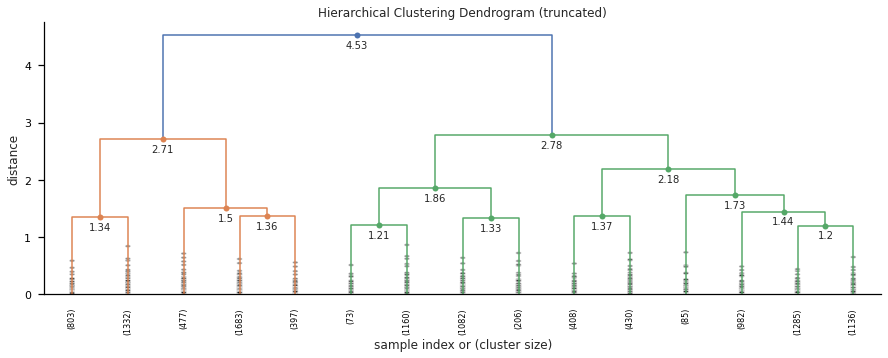

In [12]:
import matplotlib.font_manager
D = hac.linkage(clusterer.smoothed_rhythms['wma'].transpose(), "ward")
scluster_utils.plot_dendogram(D);

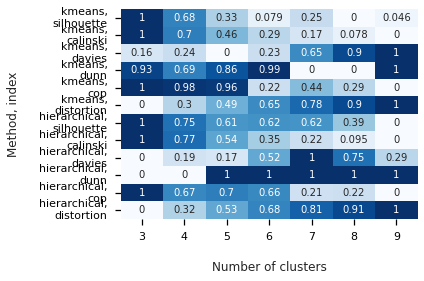

In [13]:
norm = vclust.plot()
cluster_size = norm.loc['hierarchical'].idxmax(axis=1)

In [14]:
print(', '.join([f'{v} {"votes" if v > 1 else "vote"} for {k} clusters' for k,v in cluster_size.value_counts().to_dict().items()]) + '.')
print(f'Majority vote for {cluster_size.value_counts().idxmax()}.')

3 votes for 3 clusters, 1 vote for 7 clusters, 1 vote for 5 clusters, 1 vote for 9 clusters.
Majority vote for 3.


In [15]:
num_clusters = cluster_size.value_counts().idxmax()
avg, users, results = clusterer.process_clusters(D, clusterer.smoothed_rhythms['wma'].transpose(), num_clusters)

<AxesSubplot:xlabel='min_bins15'>

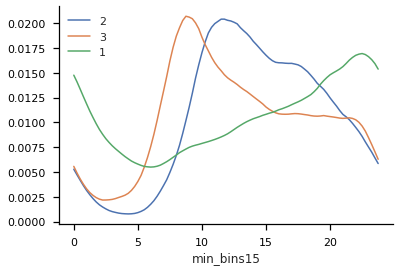

In [16]:
avg.plot()

In [17]:
results.value_counts()

1    4692
3    4326
2    2521
dtype: int64

### Assigning clusters

In [18]:
cluster_num_to_name = {
    None: Clusters.INFREQUENT.value,
    1: Clusters.EVENING.value,
    2: Clusters.INTERMEDIATE.value,
    3: Clusters.MORNING.value
}

usercol = df[Columns.USER.value].map(lambda x: scluster_utils.user_to_cluster(users, cluster_num_to_name, x))
df[Columns.CLUSTER.value] = "verified"
df[Columns.CLUSTER.value] = usercol.values

## Save aggregations

In [19]:
activity_path_manager = ActivityPathManager(config, country_config.LABEL, TYPE)
ratio_path_manager = MachinatedPathManager(config, country_config.LABEL, TYPE)
activity_rough=save_activity_per_cluster(df, activity_path_manager)
df[[Columns.CLUSTER.value]].to_parquet(get_cluster_col_path(activity_path_manager), compression='gzip')
machinated_per_cluster = save_machinated_per_cluster(df, ratio_path_manager)

## Cluster statistics

<AxesSubplot:xlabel='min_bins15', ylabel='activity'>

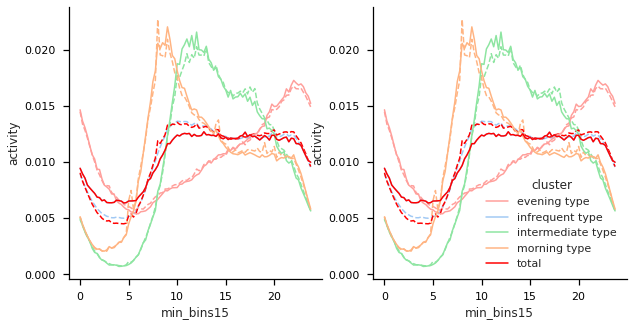

In [21]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
tmp = activity_rough.reset_index()
sns.lineplot(data=tmp, x=Columns.MIN_BINS15.value, y=Columns.ACTIVITY.value, hue=Columns.CLUSTER.value, ls="--", ax=axes[0], legend=False, palette=Clusters.palette())
sns.lineplot(data=tmp, x=Columns.MIN_BINS15.value, y=Columns.ACTIVITY_WEIGHTED.value, hue=Columns.CLUSTER.value, ax=axes[0], legend=False, palette=Clusters.palette())

tmp = tmp.loc[tmp[Columns.CLUSTER.value] !='bot']
ax = sns.lineplot(data=tmp, x=Columns.MIN_BINS15.value, y=Columns.ACTIVITY.value, hue=Columns.CLUSTER.value, ls="--", palette=Clusters.palette())
sns.lineplot(data=tmp, x=Columns.MIN_BINS15.value, y=Columns.ACTIVITY_WEIGHTED.value, hue=Columns.CLUSTER.value, ax=ax, legend=False, palette=Clusters.palette())

In [22]:
cluster_stats = scluster_utils.get_user_stats(df)

In [ ]:
activity_path_manager.to_latex(cluster_stats.style.format({'posts per user': '{:,.0f}'}, na_rep='-'), label='cluster_stats_total', caption="Statistics for each cluster.", is_multi_index=False)

In [23]:
wma=clusterer.smoothed_rhythms['wma']
infr_avg = scluster_utils.get_avg_for_cluster(df, wma, Clusters.INFREQUENT.value)
distance_stats = scluster_utils.get_distance_stats(
    {v:k for k,v in cluster_num_to_name.items()}, wma, results.values, infr_avg)

In [44]:
rename_dict = {c:c.split()[0] for c in list(Clusters)}

<p id="SupplTab12">Supplementary Table 12</p>

In [49]:
cluster_stats_total_style = (
    pd.concat((cluster_stats, distance_stats.T), axis=1, keys=["general", "distances"]).loc[list(Clusters)]
    .rename(index=rename_dict, columns=rename_dict)
    .style
    .format("{:,.0f}",subset='general')
    .format(lambda x: f'{x:,.3f}', na_rep="-", subset="distances")
    .apply(lambda d: ['font-weight: bold' if c==d.name else '' for c in d.index.get_level_values(1)], axis=1))
cluster_stats_total_style

In [50]:
activity_path_manager.to_latex(
    cluster_stats_total_style,
    label= 'cluster_stats_total',
    caption=r"Distances are given using Ward's variance minimization algorithm~\cite{Balcan2014Robust}.The maximum distance within a cluster is indicated in bold font.",
    is_multi_index=True)

# Clustering only unverified users

In [51]:
TYPE='unverified'
activity_path_manager = ActivityPathManager(config, country_config.LABEL, TYPE)
ratio_path_manager = MachinatedPathManager(config, country_config.LABEL, TYPE)

In [52]:
clusterer_unverified=scluster_utils.Clusterer(
    processor.all.loc[~processor.all[Columns.VERIFIED.value]],
    processor.posts_per_user,
    cutoff_post_nr=240, ratio_column=Columns.RATIO_BY_USER)

In [53]:
clusterer_unverified.average_over_column();

<AxesSubplot:xlabel='min_bins15'>

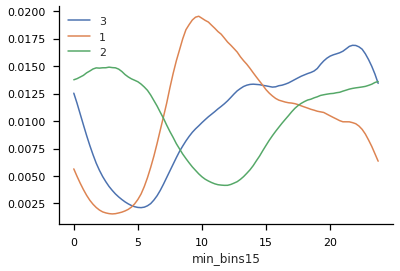

In [54]:
wma_unverified=clusterer_unverified.smoothed_rhythms['wma'][[c for c in clusterer_unverified.smoothed_rhythms['wma'].columns]]
D_unverified = hac.linkage(wma_unverified.transpose(), "ward")
avg_unverified, users_unverified, results_unverified = clusterer_unverified.process_clusters(D_unverified, wma_unverified.transpose(), num_clusters)
avg_unverified.plot()

The clusters solicited by unverified accounts only are relatively different. We can conclude that verified and unverified users differ significantly in their activity patterns.

In [55]:
unverified_cluster_num_to_name = {
    None: Clusters.INFREQUENT.value,
    1: Clusters.MORNING.value,
    2: Clusters.EVENING.value,
    3: Clusters.INTERMEDIATE.value
}

usercol_unverified = processor.all.loc[~processor.all[Columns.VERIFIED.value], Columns.USER.value].map(lambda x: scluster_utils.user_to_cluster(users_unverified, unverified_cluster_num_to_name, x));

In [56]:
processor.all[Columns.CLUSTER.value] = "verified"
processor.all.loc[~processor.all[Columns.VERIFIED.value], Columns.CLUSTER.value] = usercol_unverified

In [57]:
activity_rough=save_activity_per_cluster(processor.all, activity_path_manager)
df[[Columns.CLUSTER.value]].to_parquet(get_cluster_col_path(activity_path_manager), compression='gzip')
machinated_per_cluster = save_machinated_per_cluster(processor.all, ratio_path_manager)

In [58]:
cluster_stats = scluster_utils.get_user_stats(processor.all)
cluster_stats

,posts,users,posts per user
infrequent type,8412670,907156,9.273675
morning type,4226421,5422,779.494836
intermediate type,3472983,4189,829.072094
evening type,1530667,1580,968.776582
verified,519646,5864,88.616303


In [59]:
activity_path_manager.to_latex(
    cluster_stats.style.format({'posts per user': '{:.0f}'}, na_rep='-'),
    label='cluster_stats',
    caption=r"Statistics for each cluster.", is_multi_index=True)

In [60]:
infr_avg_unverified = scluster_utils.get_avg_for_cluster(processor.all.loc[~processor.all[Columns.VERIFIED.value]], wma_unverified, Clusters.INFREQUENT.value)
distance_stats = scluster_utils.get_distance_stats(
    {v:k for k,v in unverified_cluster_num_to_name.items()}, wma_unverified, results_unverified.values, infr_avg_unverified)

In [61]:
(distance_stats.T.loc[[Clusters.MORNING.value, Clusters.INTERMEDIATE.value, Clusters.EVENING.value, Clusters.INFREQUENT.value]]
 .style
 .format(lambda x: f'{x:.3f}')
 .apply(highlight_diag, axis=None))

,morning type,intermediate type,evening type
morning type,2.693,3.685,4.336
intermediate type,3.685,2.007,3.046
evening type,4.336,3.046,1.402
infrequent type,2.692,2.044,1.403


In [62]:
activity_path_manager.to_latex(
    distance_stats.T.loc[[Clusters.MORNING.value, Clusters.INTERMEDIATE.value, Clusters.EVENING.value, Clusters.INFREQUENT.value]].style
         .format(lambda x: f'{x:.3f}')
         .apply(highlight_diag, axis=None),
    label= 'cluster_stats_distances',
    caption=r"Distances are given using Ward's variance minimization algorithm~\cite{Balcan2014Robust}.")